In [29]:
import tensorflow_datasets as tfds
import tensorflow as tf

from tensorflow.keras.layers import (
    Input,
    Dense,
    BatchNormalization,
)
from tensorflow.keras.models import Model

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import sklearn
from sklearn.metrics import (
    confusion_matrix, 
    classification_report,
    roc_auc_score
)

import plotnine as p9

import datetime

import os

import warnings
warnings.filterwarnings('ignore')

In [30]:
print(f"Tensorflow datasets: {tfds.__version__}")
print(f"Tensorflow: {tf.__version__}")
print(f"Sklearn: {sklearn.__version__}")
print(f"Numpy: {np.__version__}")
print(f"Pandas: {pd.__version__}")
print(f"Matplotlib: {matplotlib.__version__}")
print(f"Plotnine: {p9.__version__}")

Tensorflow datasets: 4.2.0
Tensorflow: 2.4.1
Sklearn: 0.24.2
Numpy: 1.19.5
Pandas: 1.2.4
Matplotlib: 3.4.1
Plotnine: 0.8.0


In [3]:
config = tfds.ReadConfig(try_autocache=True, shuffle_seed=42)

In [4]:
import pump
data_dir = "../dataset"

(train, val, test), info = tfds.load(
    "pump",
    split=["train[:90%]", "train[90%:]", "test"],
    data_dir=data_dir,
    with_info=True,
    shuffle_files=True,
    read_config=config,
)

In [5]:
def spectral_centroid(item):
    audio = tf.cast(item["audio"], dtype = tf.float32)
    audio = audio / 2**15
    audio = tf.signal.stft(audio, frame_length=1024, frame_step=512)
    audio = tf.abs(audio)
    freqs = tf.constant(np.arange(0,513), dtype=audio.dtype)
    item["audio"] = tf.reduce_sum(audio * freqs, axis=1) / tf.reduce_sum(audio, axis=1)
    return item

In [6]:
def prep_train(item):
    return item["audio"], item["audio"]

In [7]:
BATCH_SIZE = 256
SHUFFLE_BUFFER_SIZE = 1024

train = train.map(spectral_centroid)
train2 = train.map(prep_train).batch(BATCH_SIZE)

val = train.map(spectral_centroid)
val2 = train.map(prep_train).batch(BATCH_SIZE)

test = test.map(spectral_centroid)
test2 = test.batch(BATCH_SIZE)

In [8]:
autoencoder = model = tf.keras.Sequential(
    [
        Input(shape=311),
        BatchNormalization(),
        Dense(units=128, activation='relu'),
        Dense(units=64, activation='relu'),
        Dense(units=8, activation="relu"),
        Dense(units=64, activation='relu'),
        Dense(units=128, activation='relu'),
        Dense(311, activation=None),
    ]
)

autoencoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 311)               1244      
_________________________________________________________________
dense (Dense)                (None, 128)               39936     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_3 (Dense)              (None, 64)                576       
_________________________________________________________________
dense_4 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_5 (Dense)              (None, 311)               4

In [9]:
def my_loss(y_true, y_pred):
    return tf.reduce_mean(tf.reduce_mean(tf.square(y_true-y_pred), axis=-1))

In [10]:
autoencoder.compile(optimizer='adam', loss=my_loss)

In [11]:
log_dir = os.path.join('..', 'logs', 'semi-centroid', datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
tb_callback = tf.keras.callbacks.TensorBoard(
    log_dir, update_freq=1, histogram_freq=1, write_graph=True
)

In [12]:
checkpoint_filepath = os.path.join("tmp", "semi-centroid", "checkpoint")
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [13]:
history = model.fit(
    train2,
    epochs=100,
    shuffle=True,
    validation_data=val2,
    callbacks=[tb_callback, model_checkpoint_callback],
    verbose=1,
)

Epoch 1/100
12/12 [==============================] - 42s 4s/step - loss: 19085.9309 - val_loss: 9980.3838
Epoch 2/100
12/12 [==============================] - 39s 3s/step - loss: 17230.8548 - val_loss: 53018.6445
Epoch 3/100
12/12 [==============================] - 39s 3s/step - loss: 9423.0053 - val_loss: 983061.5000
Epoch 4/100
12/12 [==============================] - 39s 3s/step - loss: 6488.3478 - val_loss: 227256.6719
Epoch 5/100
12/12 [==============================] - 39s 3s/step - loss: 6054.6587 - val_loss: 217154.7656
Epoch 6/100
12/12 [==============================] - 39s 3s/step - loss: 5734.9142 - val_loss: 122484.2578
Epoch 7/100
12/12 [==============================] - 39s 3s/step - loss: 5335.5045 - val_loss: 75764.7578
Epoch 8/100
12/12 [==============================] - 39s 3s/step - loss: 5492.6118 - val_loss: 59814.3828
Epoch 9/100
12/12 [==============================] - 39s 3s/step - loss: 5159.9671 - val_loss: 37510.9688
Epoch 10/100
12/12 [=====================

In [14]:
audios = train.concatenate(test)

In [15]:
pred = autoencoder.predict(audios.map(lambda item: item["audio"]).batch(BATCH_SIZE))

In [16]:
error_lst = []
for item, pred in zip(tfds.as_numpy(audios), pred):
    error = np.mean(np.square(item["audio"] - pred))
    error_lst.append(error)

In [17]:
audios_df = tfds.as_dataframe(audios, info)

# Convert byte-type texts to string-type texts
for col in audios_df:
    if isinstance(audios_df[col][0], bytes):
        audios_df[col] = audios_df[col].str.decode("utf8")

dct_columns = {
    "audio/id": "id", 
    "audio/machine": "machine_id", 
    "audio/split": "split",
}

# Convert object-type columns to a more convenient data type
dct_types = {
    "id": "string",
    "machine_id": "category",
    "split": "category",
    "label": "category",
}

audios_df = (
    audios_df
    .rename(columns=dct_columns)
    .astype(dct_types)
)

audios_df.sample(5)

,audio,id,machine_id,split,label
3327,"[163.07487, 161.21838, 163.3477, 167.9447, 140...",0124,00,1,1
118,"[114.06631, 117.97325, 113.59333, 121.0207, 12...",0188,02,0,0
1805,"[142.78604, 129.71992, 135.94756, 142.96118, 1...",0756,06,0,0
2111,"[133.06099, 111.36417, 114.01928, 122.676506, ...",0679,00,0,0
1094,"[193.66249, 189.3511, 188.49696, 186.62431, 20...",0498,02,0,0


In [18]:
audios_df["error"] = error_lst

In [19]:
audios_df.sample(5)

,audio,id,machine_id,split,label,error
3836,"[126.51826, 111.01998, 122.73849, 132.78821, 1...",0036,06,1,1,1275.942505
2825,"[144.79059, 139.72159, 140.94376, 138.74268, 1...",0321,04,0,0,164.986679
453,"[81.38234, 75.21779, 77.45253, 82.02454, 80.46...",0895,06,0,0,369.789551
3751,"[76.23186, 86.233955, 75.907715, 73.2001, 57.1...",0033,06,1,0,6950.905762
450,"[143.20929, 139.88228, 136.25633, 151.09628, 1...",0149,00,0,0,4996.189941


In [20]:
(
    audios_df
    .query("split == 0")
    .groupby("machine_id")
    .agg({"error": ["mean", "std"]})
)

error             
                   mean          std
machine_id                          
00          1578.129586  2152.600801
02          1602.127550  2388.100506
04          1490.602155  1952.101502
06          1552.308182  2052.818645

In [21]:
(
    audios_df
    .query("split == 1")
    .groupby(["label", "machine_id"])
    .agg({"error": ["mean", "std"]})
)

error             
                         mean          std
label machine_id                          
0     00          1755.397064  2138.856112
      02          1643.909474  2003.412155
      04          1706.000243  2101.964359
      06          1860.700432  1949.759169
1     00          1435.774675  1673.611327
      02          1601.938428  1878.721038
      04          1443.710609  1779.309144
      06          1996.163047  2145.757283

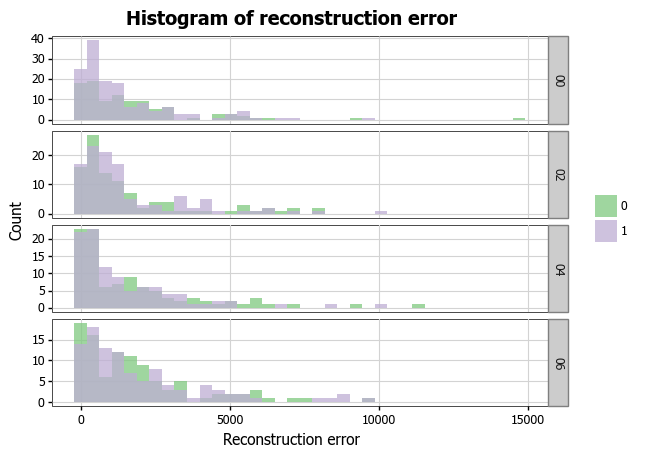

In [22]:
p = (
    p9.ggplot(audios_df.query("split == 1"), p9.aes(x="error", fill="label"))
    + p9.geom_histogram(
        p9.aes(y="stat(count)"), position="identity", alpha=0.75
    )
    + p9.scale_x_continuous(name="Reconstruction error")
    + p9.scale_y_continuous(name="Count")
    + p9.labs(
        title="Histogram of reconstruction error",
    )
    + p9.scale_fill_brewer(type="qualitative", palette="Accent") 
    + p9.facet_grid("machine_id ~ .", scales="free")
    + p9.theme_bw()
    + p9.theme(
        panel_border=p9.element_rect(colour="black", fill=None, size=0.5),
        axis_text_x=p9.element_text(colour="black", size=9),
        axis_text_y=p9.element_text(colour="black", size=9),
        legend_key=p9.element_blank(),
        legend_title=p9.element_blank(),
        panel_grid_major=p9.element_line(colour="#d3d3d3"),
        panel_grid_minor=p9.element_blank(),
        panel_background=p9.element_blank(),
        plot_title=p9.element_text(size=14, family="Tahoma", face="bold"),
        text=p9.element_text(family="Tahoma"),
    )
)

print(p)

In [23]:
avg = (
    audios_df
    .query("split == 0")
    ["error"]
    .mean()
)

std = (
    audios_df
    .query("split == 0")
    ["error"]
    .std()
)

threshold = avg + std

In [24]:
print(threshold)

3719.703408187952


In [25]:
audios_df["label_pred"] = audios_df["error"] > threshold

In [26]:
audios_df.head()

,audio,id,machine_id,split,label,error,label_pred
0,"[167.79619, 148.82285, 155.80418, 157.08049, 1...",0811,02,0,0,1363.780762,False
1,"[123.45275, 121.31313, 137.93771, 127.775246, ...",0144,00,0,0,2770.097168,False
2,"[128.69463, 133.42935, 147.16164, 122.406494, ...",0773,06,0,0,4800.701172,True
3,"[122.336296, 111.70874, 117.87651, 117.789314,...",0425,02,0,0,471.138458,False
4,"[126.35325, 128.95583, 137.11765, 142.96132, 1...",0191,04,0,0,3365.334717,False


In [31]:
machine_id = "00"
temp = (
    audios_df
    .query("machine_id == @machine_id and split == 1")
)  
print(classification_report(temp["label"], temp["label_pred"]))

              precision    recall  f1-score   support

           0       0.40      0.87      0.55       100
           1       0.50      0.09      0.15       143

    accuracy                           0.41       243
   macro avg       0.45      0.48      0.35       243
weighted avg       0.46      0.41      0.32       243



In [32]:
print(confusion_matrix(temp["label"], temp["label_pred"]))

[[ 87  13]
 [130  13]]


In [33]:
score = roc_auc_score(temp["label"], temp["label_pred"])
print(f"ROC-AUC score: {score:.4f}")

ROC-AUC score: 0.4805


In [34]:
machine_id = "02"
temp = (
    audios_df
    .query("machine_id == @machine_id and split == 1")
)  
print(classification_report(temp["label"], temp["label_pred"]))

              precision    recall  f1-score   support

           0       0.47      0.87      0.61       100
           1       0.52      0.13      0.20       111

    accuracy                           0.48       211
   macro avg       0.50      0.50      0.41       211
weighted avg       0.50      0.48      0.40       211



In [35]:
print(confusion_matrix(temp["label"], temp["label_pred"]))

[[87 13]
 [97 14]]


In [36]:
score = roc_auc_score(temp["label"], temp["label_pred"])
print(f"ROC-AUC score: {score:.4f}")

ROC-AUC score: 0.4981


In [37]:
machine_id = "04"
temp = (
    audios_df
    .query("machine_id == @machine_id and split == 1")
)  
print(classification_report(temp["label"], temp["label_pred"]))

              precision    recall  f1-score   support

           0       0.48      0.85      0.61       100
           1       0.35      0.08      0.13       100

    accuracy                           0.47       200
   macro avg       0.41      0.46      0.37       200
weighted avg       0.41      0.47      0.37       200



In [38]:
print(confusion_matrix(temp["label"], temp["label_pred"]))

[[85 15]
 [92  8]]


In [39]:
score = roc_auc_score(temp["label"], temp["label_pred"])
print(f"ROC-AUC score: {score:.4f}")

ROC-AUC score: 0.4650


In [40]:
machine_id = "06"
temp = (
    audios_df
    .query("machine_id == @machine_id and split == 1")
)  
print(classification_report(temp["label"], temp["label_pred"]))

              precision    recall  f1-score   support

           0       0.50      0.86      0.63       100
           1       0.55      0.17      0.26       102

    accuracy                           0.51       202
   macro avg       0.53      0.51      0.45       202
weighted avg       0.53      0.51      0.44       202



In [41]:
print(confusion_matrix(temp["label"], temp["label_pred"]))

[[86 14]
 [85 17]]


In [42]:
score = roc_auc_score(temp["label"], temp["label_pred"])
print(f"ROC-AUC score: {score:.4f}")

ROC-AUC score: 0.5133
